In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely import Polygon
from shapely import MultiPolygon
import h3.api.numpy_int as h3
from netCDF4 import Dataset
import cartopy.crs as ccrs
import xarray as xr
from itertools import product

In [2]:
import pysal as ps
import libpysal

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [3]:
from sklearn.cluster import AffinityPropagation

In [4]:
data_dir='test-data/ops.v16.3.2023040300'
diag_file=data_dir+'/diag_conv_uv_ges.2023040300.nc4'
diag_hdl=Dataset(diag_file)
ob_use=np.asarray(diag_hdl.variables['Analysis_Use_Flag']).squeeze()
ob_typ=np.asarray(diag_hdl.variables['Observation_Type']).squeeze()
ob_sty=np.asarray(diag_hdl.variables['Observation_Subtype']).squeeze()
ob_pre=np.asarray(diag_hdl.variables['Pressure']).squeeze()
ob_lat=np.asarray(diag_hdl.variables['Latitude']).squeeze()
ob_lon=np.asarray(diag_hdl.variables['Longitude']).squeeze()
ob_tim=np.asarray(diag_hdl.variables['Time']).squeeze()
ob_uwd=np.asarray(diag_hdl.variables['u_Observation']).squeeze()
ob_vwd=np.asarray(diag_hdl.variables['v_Observation']).squeeze()
fix=np.where(ob_lon>180.)
ob_lon[fix]=ob_lon[fix]-360.

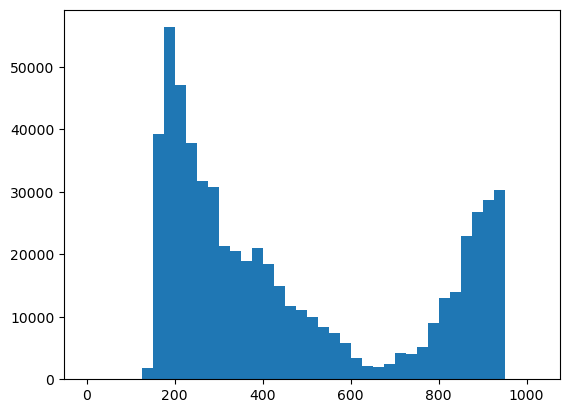

In [5]:
plt.hist(ob_pre[np.where((ob_use==1.)&(ob_typ>=240)&(ob_typ<=260))],np.arange(0.,1026.,25.))
plt.show()

In [6]:
opt_tim=1.5 # select observations around this time (hrs) in the time-window (0==analysis-time)
opt_pre=225. # select observations around this pressure-level (hPa)
# Select subset of data from lat, lon, prs, tim: 
idx=np.where((ob_use==1.)&
             (np.abs(ob_pre-opt_pre)<25.)&
             (np.abs(ob_tim-opt_tim)<0.5)&
             (ob_typ>=240)&(ob_typ<=260)
            )[0]
print('{:d} observations in range'.format(np.size(idx)))
# Construct a geopandas point dataset that contains all relevant ob-info
point_list=[]
nob_list=[]
for i in idx:
    point_list.append(Point(ob_lon[i],ob_lat[i]))
    nob_list.append(1)
d = {'geometry': point_list, 
     'lat': list(ob_lat[idx]),
     'lon': list(ob_lon[idx]),
     'pre': list(ob_pre[idx]),
     'tim': list(ob_tim[idx]),
     'uwd': list(ob_uwd[idx]),
     'vwd': list(ob_vwd[idx]),
     'nob': nob_list,
     'ob_idx': list(idx)
    }
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
# Transform gdf into cylindrical equidistant projection, where Point() units are in m
gdfE = gdf.to_crs("EPSG:4087")

gdfE

3058 observations in range


,geometry,lat,lon,pre,tim,uwd,vwd,nob,ob_idx
0,POINT (668037.174 -5115089.496),-45.949631,6.001080,248.699997,1.5,59.998913,33.257938,1,5266
1,POINT (670388.249 -5111596.324),-45.918251,6.022200,248.899994,1.5,60.881584,35.150002,1,5532
2,POINT (758405.222 -4979241.787),-44.729290,6.812870,244.100006,1.5,53.086880,44.545181,1,5536
3,POINT (729048.042 -5163292.809),-46.382648,6.549150,247.399994,1.5,64.084602,43.225613,1,5542
4,POINT (670642.031 -5108125.233),-45.887070,6.024480,245.100006,1.5,61.059464,38.154186,1,5545
...,...,...,...,...,...,...,...,...,...
3053,POINT (-421052.521 1219683.154),10.956600,-3.782379,240.600006,1.5,16.320065,13.215728,1,1839731
3054,POINT (-147951.512 1430555.610),12.850900,-1.329071,221.800003,1.5,16.845360,18.064436,1,1839734
3055,POINT (-190650.935 1628263.487),14.626940,-1.712646,213.899994,1.5,26.555962,20.747791,1,1839744
3056,POINT (-528696.240 935064.783),8.399830,-4.749359,228.000000,1.5,22.552368,9.572912,1,1839776


In [7]:
# Define weights by a DistanceBand cutoff distance around each ob
distThreshold=1000.*100. # m
w=libpysal.weights.distance.DistanceBand.from_dataframe(gdfE,threshold=distThreshold) # threshold in m

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 1245 disconnected components.
 There are 758 islands with ids: 7, 35, 37, 54, 61, 64, 86, 138, 144, 160, 161, 171, 202, 209, 210, 243, 255, 257, 282, 285, 299, 302, 313, 318, 320, 379, 381, 389, 391, 411, 476, 480, 486, 494, 501, 536, 537, 543, 545, 571, 606, 617, 631, 633, 663, 671, 692, 696, 705, 713, 723, 733, 734, 739, 747, 752, 755, 781, 790, 807, 846, 850, 875, 961, 1018, 1033, 1063, 1150, 1151, 1175, 1185, 1200, 1203, 1208, 1229, 1252, 1265, 1325, 1327, 1329, 1330, 1333, 1335, 1336, 1337, 1338, 1340, 1345, 1346, 1347, 1348, 1349, 1352, 1355, 1357, 1380, 1418, 1420, 1424, 1425, 1427, 1428, 1429, 1434, 1438, 1474, 1512, 1513, 1515, 1516, 1517, 1529, 1535, 1536, 1537, 1538, 1539, 1540, 1543, 1544, 1545, 1551, 1552, 1553, 1554, 1559, 1564, 1567, 1573, 1576, 1587, 1590, 1591, 1593, 1594, 1596, 1605, 1606

In [8]:
# define features for clustering:
# 1. u-component
# 2. v-component
# predictors are stored in a matrix of {n_samples, n_features}
n_feat = 2
X = np.nan * np.ones((np.size(idx),n_feat))
X[:,0] = ob_uwd[idx]
X[:,1] = ob_vwd[idx]
print(np.shape(X))

(3058, 2)


In [9]:
# define settings for affinity propagation and generate clustering
# see for details:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation
dampCoef  = 0.65  # can be increased up to 0.95, if not converging - lower value may or may not produce more indiv. clusters
iterMax   = 500   # set higher than iterCnv
iterCnv   = 200   # can be increased if not converging (try increasing dampCoef first, though)
cop       = True
pref      = None
affTyp    = 'euclidean'
outVerb   = True
randState = 90210  # sets random number seed, for reproducibility
clustering = AffinityPropagation(
                                 damping=dampCoef,
                                 max_iter=iterMax,
                                 convergence_iter=iterCnv,
                                 copy=cop,
                                 preference=pref,
                                 affinity=affTyp,
                                 verbose=outVerb,
                                 random_state=randState
                                ).fit(X)
nClusters = np.size(np.unique(clustering.labels_))
clusterIndices = list(np.unique(clustering.labels_))
print('{:d} observations reduced to {:d} clusters'.format(np.size(idx), nClusters))

Converged after 406 iterations.
3058 observations reduced to 64 clusters


In [10]:
scalarMap = cm.ScalarMappable(cmap='gist_rainbow')
scalarMapList = scalarMap.to_rgba(range(nClusters))

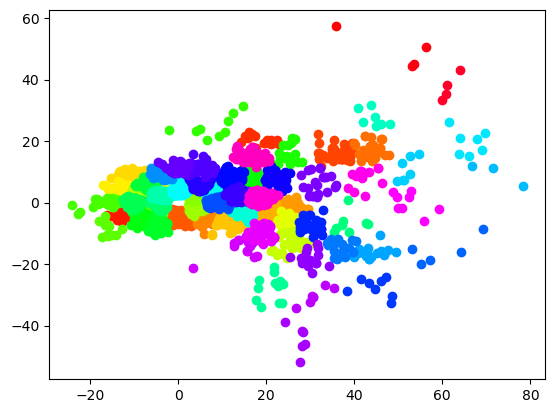

In [11]:
plt.plot(ob_uwd[idx],ob_vwd[idx],'.',color='black')
for i in range(nClusters):
    c = clusterIndices[i]
    cluster_color = list(scalarMapList[i][0:3])
    x=np.where(clustering.labels_==c)[0]
    plt.plot(ob_uwd[idx[x]],ob_vwd[idx[x]],'o',color=cluster_color)
plt.show()

In [12]:
# Distance-band based neighbors are contained in the tuple w.full() as:
#  w.full()[0]: {n_samples,n_samples} array with each row [i,:] representing all neighbors for sample i
#  w.full()[1]: {n_samples,} vector giving index of each data-point
# NOTE: Since distance-band is symmetrical by design, w.full()[0][i,:] == w.full()[0][:,i]
#
# Obs can be combined into clusters if they have proximity (distance-band neighbor relation) and are
# part of same affinity propagation cluster
#
# For now, let's assign every observation to the last cluster-index it gets assigned to. I would ideally
# like to keep track of all cases where a single observation falls into more than one cluster by
# this definition, which can happen if an aff.prop. cluster stretches across more than the distance-band
# in physical space and there is an observation that can link to two proximity-based groups that are in
# the same aff.prop. cluster.
nGenuineClusters = 0
genuineClusterIndex = np.nan * np.ones((np.size(idx),))  # [np.asarray([],dtype='int32') for i in range(np.size(idx))]
for i in range(np.size(idx)):
    GCNum = nGenuineClusters
    # automatically assign observation i to cluster GCNum
    genuineClusterIndex[i] = GCNum  # np.append(genuineClusterIndex[i],GCNum)
    # loop through all observations in distance-band neighborhood of observation i
    for j in np.where(w.full()[0][:,i]==1)[0]:
        # assign observation j to cluster GCNum if its clustering.labels_ value matches observation i
        if clustering.labels_[j] == clustering.labels_[i]:
            genuineClusterIndex[j] = GCNum  # np.append(genuineClusterIndex[j],GCNum)
    # increment nGenuineClusters
    nGenuineClusters = nGenuineClusters + 1

In [13]:
print('{:d} observations assigned to {:d} clusters'.format(np.size(idx),np.size(np.unique(genuineClusterIndex))))

3058 observations assigned to 1812 clusters


In [14]:
scalarMap = cm.ScalarMappable(cmap='tab20')
scalarMapList = scalarMap.to_rgba(range(20))

#scalarMap = cm.ScalarMappable(cmap='gist_rainbow')
#scalarMapList = scalarMap.to_rgba(range(np.size(np.unique(genuineClusterIndex))))

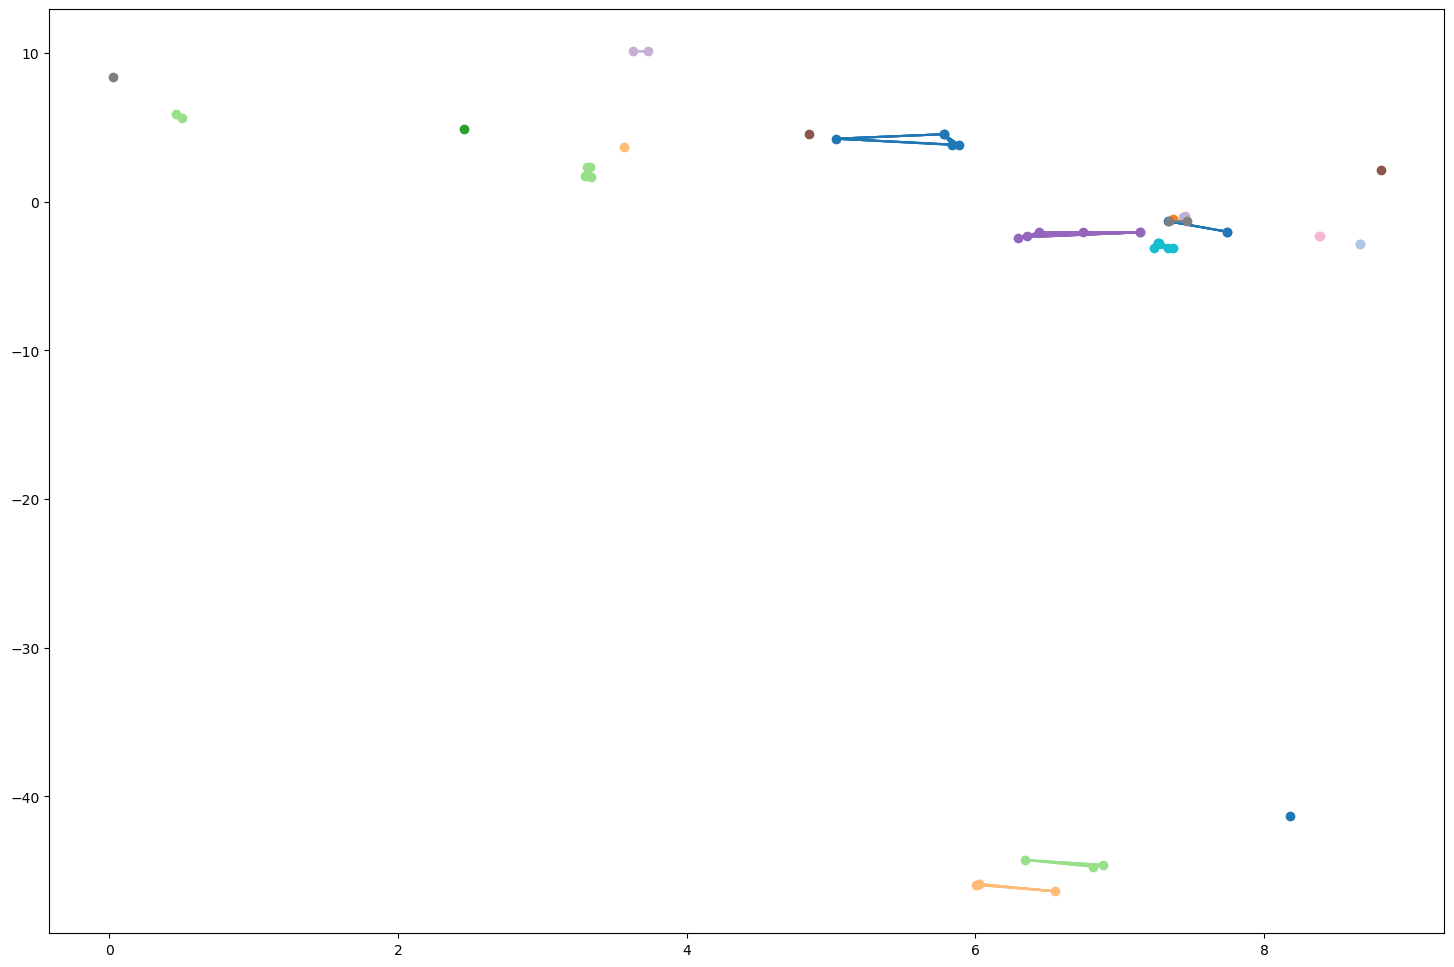

In [15]:
fig=plt.figure(figsize=(18,12))
for i in np.unique(genuineClusterIndex)[0:20]:
    r=np.random.randint(low=0,high=19)#np.size(np.unique(genuineClusterIndex)))
    col=list(scalarMapList[r][0:3])
    jdx=idx[np.where(genuineClusterIndex==i)[0]]
    if np.size(jdx) > 1:
        l = list(product(jdx,jdx))
        for p in l:
            if p[0] != p[1]:
                plt.plot((ob_lon[p[0]],ob_lon[p[1]]),(ob_lat[p[0]],ob_lat[p[1]]),color=col)
    plt.plot(ob_lon[jdx],ob_lat[jdx],'o',color=col)
#plt.xlim(-180.,180.)
#plt.ylim(-90.,90.)
plt.show()

In [16]:
# are clusters more similar than merely proximity?
u_rng_prox=np.asarray([])  # u-component "range" (deviation from mean of proximity-group)
v_rng_prox=np.asarray([])  # v-component "range" (deviation from mean of proximity-group)
u_rng_clus=np.asarray([])  # u-component "range" (deviation from mean of cluster-group)
v_rng_clus=np.asarray([])  # v-component "range" (deviation from mean of cluster-group)
u_nob_prox=np.nan * np.ones((np.size(idx)))  # number of u-component obs in proximity-group
v_nob_prox=np.nan * np.ones((np.size(idx)))  # number of v-component obs in proximity-group
u_nob_clus=np.nan * np.ones((np.size(idx)))  # number of u-component obs in cluster-group
v_nob_clus=np.nan * np.ones((np.size(idx)))  # number of v-component obs in cluster-group

for i in range(np.size(idx)):
    # find proximity matches to observation i, produce u- and v- subsets
    neigh = np.where(w.full()[0][:,i]==1)[0]
    uprox = np.append(ob_uwd[idx[i]],ob_uwd[idx[neigh]])
    vprox = np.append(ob_vwd[idx[i]],ob_vwd[idx[neigh]])
    u_nob_prox[i] = np.size(uprox)
    v_nob_prox[i] = np.size(vprox)
    # find cluster matches to observation i, produce u- and v- subsets
    clust = np.where(genuineClusterIndex==genuineClusterIndex[i])
    uclus = ob_uwd[idx[clust]]
    vclus = ob_vwd[idx[clust]]
    u_nob_clus[i] = np.size(uclus)
    v_nob_clus[i] = np.size(vclus)
    # if there are at least 2 obs in proximity (at least 1 neighbor),
    # compute u- and v- range as deviation of ob-mean
    if np.size(neigh) > 0:
        u_rng_prox = np.append(u_rng_prox,uprox-np.mean(uprox))
        v_rng_prox = np.append(v_rng_prox,vprox-np.mean(vprox))
    # if there are least 2 obs in cluster, compute u- and v- range
    # as deviation of ob-mean
    if np.size(clust) > 1:
        u_rng_clus = np.append(u_rng_clus,uclus-np.mean(uclus))
        v_rng_clus = np.append(v_rng_clus,vclus-np.mean(vclus))

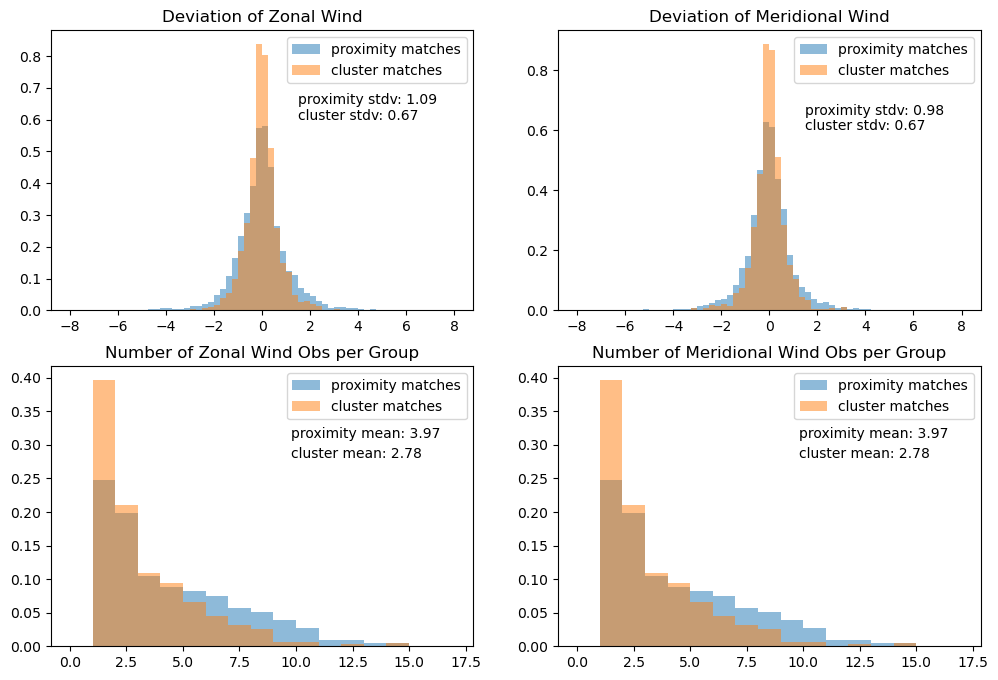

In [17]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(12,8))
ax=axs[0][0]
ax.hist(u_rng_prox,np.arange(-8.,8.1,0.25),alpha=0.5,density=True)
ax.hist(u_rng_clus,np.arange(-8.,8.1,0.25),alpha=0.5,density=True)
ax.legend(['proximity matches','cluster matches'])
ax.text(x=1.5,y=0.65,s='proximity stdv: {:.2f}'.format(np.std(u_rng_prox)))
ax.text(x=1.5,y=0.60,s='cluster stdv: {:.2f}'.format(np.std(u_rng_clus)))
ax.set_title('Deviation of Zonal Wind')
ax=axs[0][1]
ax.hist(v_rng_prox,np.arange(-8.,8.1,0.25),alpha=0.5,density=True)
ax.hist(v_rng_clus,np.arange(-8.,8.1,0.25),alpha=0.5,density=True)
ax.legend(['proximity matches','cluster matches'])
ax.text(x=1.5,y=0.65,s='proximity stdv: {:.2f}'.format(np.std(v_rng_prox)))
ax.text(x=1.5,y=0.60,s='cluster stdv: {:.2f}'.format(np.std(v_rng_clus)))
ax.set_title('Deviation of Meridional Wind')
ax=axs[1][0]
ax.hist(u_nob_prox,np.arange(18),alpha=0.5,density=True)
ax.hist(u_nob_clus,np.arange(18),alpha=0.5,density=True)
ax.legend(['proximity matches','cluster matches'])
ax.text(x=9.8,y=0.31,s='proximity mean: {:.2f}'.format(np.mean(u_nob_prox)))
ax.text(x=9.8,y=0.28,s='cluster mean: {:.2f}'.format(np.mean(u_nob_clus)))
ax.set_title('Number of Zonal Wind Obs per Group')
ax=axs[1][1]
ax.hist(v_nob_prox,np.arange(18),alpha=0.5,density=True)
ax.hist(v_nob_clus,np.arange(18),alpha=0.5,density=True)
ax.legend(['proximity matches','cluster matches'])
ax.text(x=9.8,y=0.31,s='proximity mean: {:.2f}'.format(np.mean(v_nob_prox)))
ax.text(x=9.8,y=0.28,s='cluster mean: {:.2f}'.format(np.mean(v_nob_clus)))
ax.set_title('Number of Meridional Wind Obs per Group')
plt.show()

In [18]:
# What if we treat u- and v- winds as separate observations, and allow each to cluster separately
# of each other?

In [19]:
# define features for clustering:
# 1. u-component
# predictors are stored in a matrix of {n_samples, n_features}
n_feat = 1
X = np.nan * np.ones((np.size(idx),n_feat))
X[:,0] = ob_uwd[idx]
# define settings for affinity propagation and generate clustering
# see for details:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation
dampCoef  = 0.85  # can be increased up to 0.95, if not converging - lower value may or may not produce more indiv. clusters
iterMax   = 500   # set higher than iterCnv
iterCnv   = 200   # can be increased if not converging (try increasing dampCoef first, though)
cop       = True
pref      = None
affTyp    = 'euclidean'
outVerb   = True
randState = 90210  # sets random number seed, for reproducibility
uclustering = AffinityPropagation(
                                 damping=dampCoef,
                                 max_iter=iterMax,
                                 convergence_iter=iterCnv,
                                 copy=cop,
                                 preference=pref,
                                 affinity=affTyp,
                                 verbose=outVerb,
                                 random_state=randState
                                ).fit(X)
nuClusters = np.size(np.unique(uclustering.labels_))
uclusterIndices = list(np.unique(uclustering.labels_))
print('{:d} u-wind observations reduced to {:d} clusters'.format(np.size(idx), nuClusters))

Converged after 327 iterations.
3058 u-wind observations reduced to 26 clusters


In [20]:
# define features for clustering:
# 1. v-component
# predictors are stored in a matrix of {n_samples, n_features}
n_feat = 1
X = np.nan * np.ones((np.size(idx),n_feat))
X[:,0] = ob_vwd[idx]
# define settings for affinity propagation and generate clustering
# see for details:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation
dampCoef  = 0.85  # can be increased up to 0.95, if not converging - lower value may or may not produce more indiv. clusters
iterMax   = 500   # set higher than iterCnv
iterCnv   = 200   # can be increased if not converging (try increasing dampCoef first, though)
cop       = True
pref      = None
affTyp    = 'euclidean'
outVerb   = True
randState = 90210  # sets random number seed, for reproducibility
vclustering = AffinityPropagation(
                                 damping=dampCoef,
                                 max_iter=iterMax,
                                 convergence_iter=iterCnv,
                                 copy=cop,
                                 preference=pref,
                                 affinity=affTyp,
                                 verbose=outVerb,
                                 random_state=randState
                                ).fit(X)
nvClusters = np.size(np.unique(vclustering.labels_))
vclusterIndices = list(np.unique(vclustering.labels_))
print('{:d} v-wind observations reduced to {:d} clusters'.format(np.size(idx), nvClusters))

Converged after 354 iterations.
3058 v-wind observations reduced to 36 clusters


In [21]:
# Distance-band based neighbors are contained in the tuple w.full() as:
#  w.full()[0]: {n_samples,n_samples} array with each row [i,:] representing all neighbors for sample i
#  w.full()[1]: {n_samples,} vector giving index of each data-point
# NOTE: Since distance-band is symmetrical by design, w.full()[0][i,:] == w.full()[0][:,i]
#
# Obs can be combined into clusters if they have proximity (distance-band neighbor relation) and are
# part of same affinity propagation cluster
#
# For now, let's assign every observation to the last cluster-index it gets assigned to. I would ideally
# like to keep track of all cases where a single observation falls into more than one cluster by
# this definition, which can happen if an aff.prop. cluster stretches across more than the distance-band
# in physical space and there is an observation that can link to two proximity-based groups that are in
# the same aff.prop. cluster.
nuGenuineClusters = 0
ugenuineClusterIndex = np.nan * np.ones((np.size(idx),))  # [np.asarray([],dtype='int32') for i in range(np.size(idx))]
for i in range(np.size(idx)):
    GCNum = nuGenuineClusters
    # automatically assign observation i to cluster GCNum
    ugenuineClusterIndex[i] = GCNum
    # loop through all observations in distance-band neighborhood of observation i
    for j in np.where(w.full()[0][:,i]==1)[0]:
        # assign observation j to cluster GCNum if its uclustering.labels_ value matches observation i
        if uclustering.labels_[j] == uclustering.labels_[i]:
            ugenuineClusterIndex[j] = GCNum
    # increment nuGenuineClusters
    nuGenuineClusters = nuGenuineClusters + 1

In [22]:
# Distance-band based neighbors are contained in the tuple w.full() as:
#  w.full()[0]: {n_samples,n_samples} array with each row [i,:] representing all neighbors for sample i
#  w.full()[1]: {n_samples,} vector giving index of each data-point
# NOTE: Since distance-band is symmetrical by design, w.full()[0][i,:] == w.full()[0][:,i]
#
# Obs can be combined into clusters if they have proximity (distance-band neighbor relation) and are
# part of same affinity propagation cluster
#
# For now, let's assign every observation to the last cluster-index it gets assigned to. I would ideally
# like to keep track of all cases where a single observation falls into more than one cluster by
# this definition, which can happen if an aff.prop. cluster stretches across more than the distance-band
# in physical space and there is an observation that can link to two proximity-based groups that are in
# the same aff.prop. cluster.
nvGenuineClusters = 0
vgenuineClusterIndex = np.nan * np.ones((np.size(idx),))  # [np.asarray([],dtype='int32') for i in range(np.size(idx))]
for i in range(np.size(idx)):
    GCNum = nvGenuineClusters
    # automatically assign observation i to cluster GCNum
    vgenuineClusterIndex[i] = GCNum
    # loop through all observations in distance-band neighborhood of observation i
    for j in np.where(w.full()[0][:,i]==1)[0]:
        # assign observation j to cluster GCNum if its vclustering.labels_ value matches observation i
        if vclustering.labels_[j] == vclustering.labels_[i]:
            vgenuineClusterIndex[j] = GCNum
    # increment nvGenuineClusters
    nvGenuineClusters = nvGenuineClusters + 1

In [23]:
# are clusters more similar than merely proximity?
u_rng_prox=np.asarray([])  # u-component "range" (deviation from mean of proximity-group)
v_rng_prox=np.asarray([])  # v-component "range" (deviation from mean of proximity-group)
u_rng_clus=np.asarray([])  # u-component "range" (deviation from mean of cluster-group)
v_rng_clus=np.asarray([])  # v-component "range" (deviation from mean of cluster-group)
u_nob_prox=np.nan * np.ones((np.size(idx)))  # number of u-component obs in proximity-group
v_nob_prox=np.nan * np.ones((np.size(idx)))  # number of v-component obs in proximity-group
u_nob_clus=np.nan * np.ones((np.size(idx)))  # number of u-component obs in cluster-group
v_nob_clus=np.nan * np.ones((np.size(idx)))  # number of v-component obs in cluster-group

for i in range(np.size(idx)):
    # find proximity matches to observation i, produce u- and v- subsets
    neigh = np.where(w.full()[0][:,i]==1)[0]
    uprox = np.append(ob_uwd[idx[i]],ob_uwd[idx[neigh]])
    vprox = np.append(ob_vwd[idx[i]],ob_vwd[idx[neigh]])
    u_nob_prox[i] = np.size(uprox)
    v_nob_prox[i] = np.size(vprox)
    # find cluster matches to observation i, produce u- and v- subsets
    uclust = np.where(ugenuineClusterIndex==ugenuineClusterIndex[i])
    uclus = ob_uwd[idx[uclust]]
    vclust = np.where(vgenuineClusterIndex==vgenuineClusterIndex[i])
    vclus = ob_vwd[idx[vclust]]
    u_nob_clus[i] = np.size(uclus)
    v_nob_clus[i] = np.size(vclus)
    # if there are at least 2 obs in proximity (at least 1 neighbor),
    # compute u- and v- range as deviation of ob-mean
    if np.size(neigh) > 0:
        u_rng_prox = np.append(u_rng_prox,uprox-np.mean(uprox))
        v_rng_prox = np.append(v_rng_prox,vprox-np.mean(vprox))
    # if there are least 2 obs in cluster, compute u- and v- range
    # as deviation of ob-mean
    if np.size(uclust) > 1:
        u_rng_clus = np.append(u_rng_clus,uclus-np.mean(uclus))
    if np.size(vclust) > 1:
        v_rng_clus = np.append(v_rng_clus,vclus-np.mean(vclus))

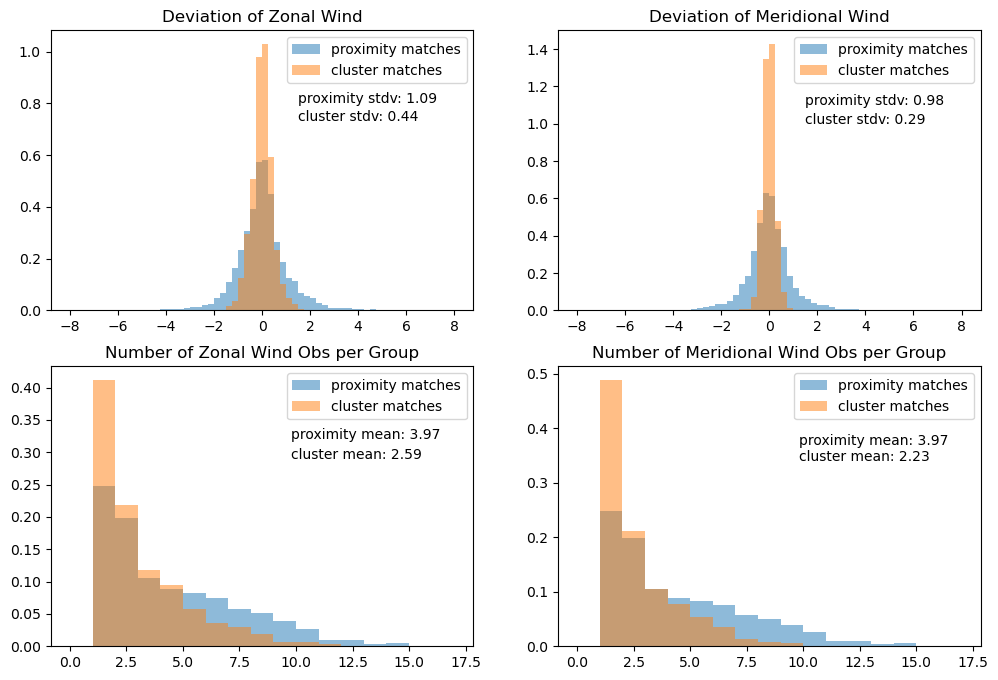

In [24]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(12,8))
ax=axs[0][0]
ax.hist(u_rng_prox,np.arange(-8.,8.1,0.25),alpha=0.5,density=True)
ax.hist(u_rng_clus,np.arange(-8.,8.1,0.25),alpha=0.5,density=True)
ax.legend(['proximity matches','cluster matches'])
ax.text(x=1.5,y=0.80,s='proximity stdv: {:.2f}'.format(np.std(u_rng_prox)))
ax.text(x=1.5,y=0.73,s='cluster stdv: {:.2f}'.format(np.std(u_rng_clus)))
ax.set_title('Deviation of Zonal Wind')
ax=axs[0][1]
ax.hist(v_rng_prox,np.arange(-8.,8.1,0.25),alpha=0.5,density=True)
ax.hist(v_rng_clus,np.arange(-8.,8.1,0.25),alpha=0.5,density=True)
ax.legend(['proximity matches','cluster matches'])
ax.text(x=1.5,y=1.10,s='proximity stdv: {:.2f}'.format(np.std(v_rng_prox)))
ax.text(x=1.5,y=1.00,s='cluster stdv: {:.2f}'.format(np.std(v_rng_clus)))
ax.set_title('Deviation of Meridional Wind')
ax=axs[1][0]
ax.hist(u_nob_prox,np.arange(18),alpha=0.5,density=True)
ax.hist(u_nob_clus,np.arange(18),alpha=0.5,density=True)
ax.legend(['proximity matches','cluster matches'])
ax.text(x=9.8,y=0.32,s='proximity mean: {:.2f}'.format(np.mean(u_nob_prox)))
ax.text(x=9.8,y=0.29,s='cluster mean: {:.2f}'.format(np.mean(u_nob_clus)))
ax.set_title('Number of Zonal Wind Obs per Group')
ax=axs[1][1]
ax.hist(v_nob_prox,np.arange(18),alpha=0.5,density=True)
ax.hist(v_nob_clus,np.arange(18),alpha=0.5,density=True)
ax.legend(['proximity matches','cluster matches'])
ax.text(x=9.8,y=0.37,s='proximity mean: {:.2f}'.format(np.mean(v_nob_prox)))
ax.text(x=9.8,y=0.34,s='cluster mean: {:.2f}'.format(np.mean(v_nob_clus)))
ax.set_title('Number of Meridional Wind Obs per Group')
plt.show()

In [25]:
# splitting u- and v- apart like this might be the clustering equivalent to overfitting to the data; while
# it is producing more coherent clusters, it might be doing so at the cost of losing sight of what it is
# we are trying to measure for similarity. These are vectors, after all, and the similarity measure should
# be applied to both components of that vector, "are these VECTORS similar?"

In [26]:
# what if we split up the affinity propagation between u- and v- components, and then only form clusters
# when there is: (1) proximity, (2) u-component similarity, AND (3) v-component similarity?

In [27]:
# are clusters more similar than merely proximity?
u_rng_prox=np.asarray([])  # u-component "range" (deviation from mean of proximity-group)
v_rng_prox=np.asarray([])  # v-component "range" (deviation from mean of proximity-group)
u_rng_clus=np.asarray([])  # u-component "range" (deviation from mean of cluster-group)
v_rng_clus=np.asarray([])  # v-component "range" (deviation from mean of cluster-group)
u_nob_prox=np.nan * np.ones((np.size(idx)))  # number of u-component obs in proximity-group
v_nob_prox=np.nan * np.ones((np.size(idx)))  # number of v-component obs in proximity-group
u_nob_clus=np.nan * np.ones((np.size(idx)))  # number of u-component obs in cluster-group
v_nob_clus=np.nan * np.ones((np.size(idx)))  # number of v-component obs in cluster-group

for i in range(np.size(idx)):
    # find proximity matches to observation i, produce u- and v- subsets
    neigh = np.where(w.full()[0][:,i]==1)[0]
    uprox = np.append(ob_uwd[idx[i]],ob_uwd[idx[neigh]])
    vprox = np.append(ob_vwd[idx[i]],ob_vwd[idx[neigh]])
    u_nob_prox[i] = np.size(uprox)
    v_nob_prox[i] = np.size(vprox)
    # find cluster matches to observation i, produce u- and v- subsets
    clust = np.where((ugenuineClusterIndex==ugenuineClusterIndex[i]) &
                      (vgenuineClusterIndex==vgenuineClusterIndex[i]))
    uclus = ob_uwd[idx[clust]]
    vclus = ob_vwd[idx[clust]]
    u_nob_clus[i] = np.size(uclus)
    v_nob_clus[i] = np.size(vclus)
    # if there are at least 2 obs in proximity (at least 1 neighbor),
    # compute u- and v- range as deviation of ob-mean
    if np.size(neigh) > 0:
        u_rng_prox = np.append(u_rng_prox,uprox-np.mean(uprox))
        v_rng_prox = np.append(v_rng_prox,vprox-np.mean(vprox))
    # if there are least 2 obs in cluster, compute u- and v- range
    # as deviation of ob-mean
    if np.size(clust) > 1:
        u_rng_clus = np.append(u_rng_clus,uclus-np.mean(uclus))
        v_rng_clus = np.append(v_rng_clus,vclus-np.mean(vclus))

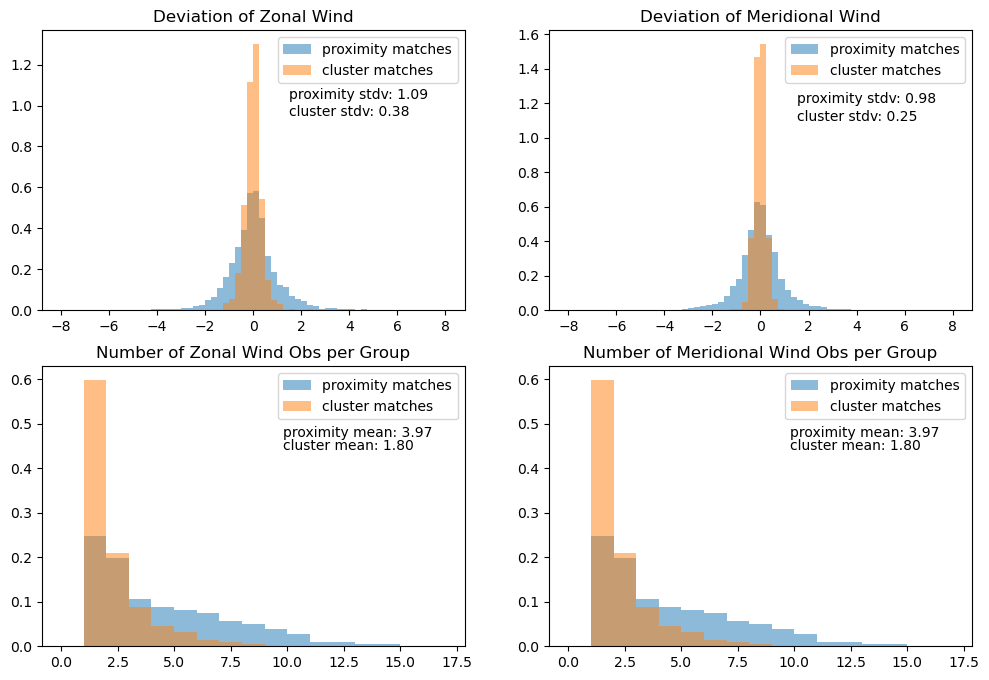

In [28]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(12,8))
ax=axs[0][0]
ax.hist(u_rng_prox,np.arange(-8.,8.1,0.25),alpha=0.5,density=True)
ax.hist(u_rng_clus,np.arange(-8.,8.1,0.25),alpha=0.5,density=True)
ax.legend(['proximity matches','cluster matches'])
ax.text(x=1.5,y=1.03,s='proximity stdv: {:.2f}'.format(np.std(u_rng_prox)))
ax.text(x=1.5,y=0.95,s='cluster stdv: {:.2f}'.format(np.std(u_rng_clus)))
ax.set_title('Deviation of Zonal Wind')
ax=axs[0][1]
ax.hist(v_rng_prox,np.arange(-8.,8.1,0.25),alpha=0.5,density=True)
ax.hist(v_rng_clus,np.arange(-8.,8.1,0.25),alpha=0.5,density=True)
ax.legend(['proximity matches','cluster matches'])
ax.text(x=1.5,y=1.20,s='proximity stdv: {:.2f}'.format(np.std(v_rng_prox)))
ax.text(x=1.5,y=1.10,s='cluster stdv: {:.2f}'.format(np.std(v_rng_clus)))
ax.set_title('Deviation of Meridional Wind')
ax=axs[1][0]
ax.hist(u_nob_prox,np.arange(18),alpha=0.5,density=True)
ax.hist(u_nob_clus,np.arange(18),alpha=0.5,density=True)
ax.legend(['proximity matches','cluster matches'])
ax.text(x=9.8,y=0.47,s='proximity mean: {:.2f}'.format(np.mean(u_nob_prox)))
ax.text(x=9.8,y=0.44,s='cluster mean: {:.2f}'.format(np.mean(u_nob_clus)))
ax.set_title('Number of Zonal Wind Obs per Group')
ax=axs[1][1]
ax.hist(v_nob_prox,np.arange(18),alpha=0.5,density=True)
ax.hist(v_nob_clus,np.arange(18),alpha=0.5,density=True)
ax.legend(['proximity matches','cluster matches'])
ax.text(x=9.8,y=0.47,s='proximity mean: {:.2f}'.format(np.mean(v_nob_prox)))
ax.text(x=9.8,y=0.44,s='cluster mean: {:.2f}'.format(np.mean(v_nob_clus)))
ax.set_title('Number of Meridional Wind Obs per Group')
plt.show()

In [29]:
# here we appear to trade cluster density for more refined clusters with greater in-group similarity